**Data Generation for Randomized Controlled Trials (RCTs):**

I simulated data for an energy usage study involving 100 households over 24 hours. Half of the households were designated as treatment households (50), and the rest as control households.

**Energy Usage Simulation:**

Using a function generate_energy_usage, I simulated energy usage based on whether a household is in the treatment group or control group, and the time of day (peak hours vs. non-peak hours).

**Random Variables and Noise:**

Random base loads and peak loads were assigned to each household to introduce variability in energy consumption.
I added random noise to energy usage data to simulate measurement errors or unaccounted factors.

**Temperature Simulation:**

Temperature data was generated assuming a normal distribution centered around noon, with peak and base temperatures defined.
Each household was assigned a temperature profile based on the simulated distribution, adding further complexity to the energy usage model.

**Panel Data Setup:**

The generated data was structured into a panel DataFrame (df_s) indexed by household ID and hour, suitable for panel data analysis.

**Regression Model:**

I specified a PanelOLS regression model to estimate the relationship between energy usage (dependent variable) and temperature, controlling for treatment status and interaction effects with hour of the day (hour2).

**Interpreting Results:**

The regression results (res) were printed and summarized to interpret the coefficients:

R-squared: Measure of goodness-of-fit of the model.

Coefficient for temperature: Estimated effect of temperature on energy usage.

Standard Error: Measure of uncertainty around the coefficient estimate.

P-value: Indicates the statistical significance of the coefficient.

In [ ]:
!pip install linearmodels
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
import matplotlib.pyplot as plt
!pip install prophet
from prophet import Prophet

                          PanelOLS Estimation Summary                           
Dep. Variable:           energy_usage   R-squared:                        0.7018
Estimator:                   PanelOLS   R-squared (Between):              0.3381
No. Observations:                2400   R-squared (Within):               0.8332
Date:                Mon, Jul 22 2024   R-squared (Overall):              0.7018
Time:                        01:39:12   Log-likelihood                   -6434.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      115.29
Entities:                         100   P-value                           0.0000
Avg Obs:                       24.000   Distribution:                 F(48,2351)
Min Obs:                       24.000                                           
Max Obs:                       24.000   F-statistic (robust):             115.31
                            

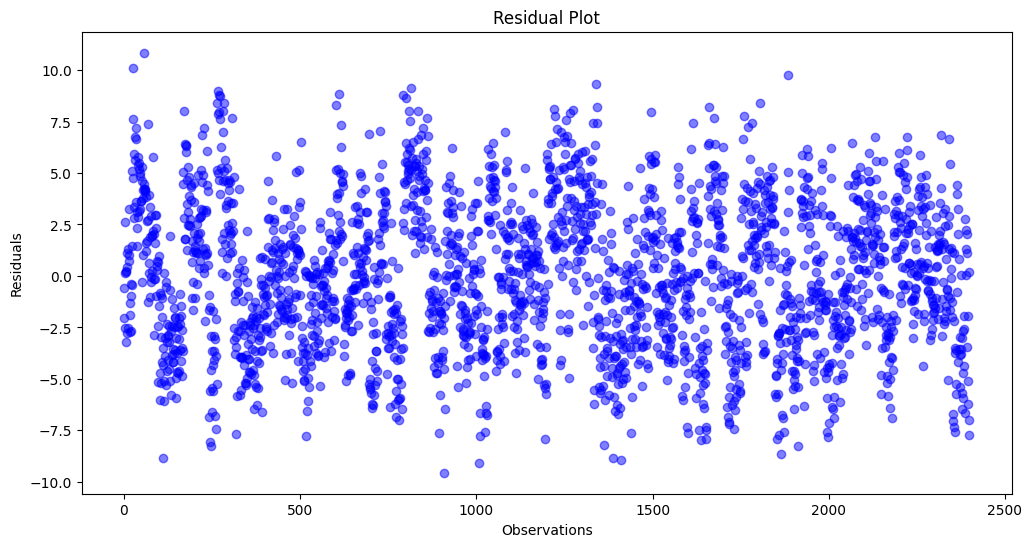


R-squared: 0.7018340643866059
Coefficient for temperature: 0.41099491518226833
Standard Error for temperature: 22830.828578927027
P-value for temperature: 0.9999856382072541


In [17]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
from scipy.stats import norm  # Import norm from scipy.stats

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_households = 100
n_hours = 24
treatment_households = 50

# Create base DataFrame with correct household IDs
households = np.repeat(np.arange(n_households), n_hours)
df = pd.DataFrame({
    'household_id': households,
    'hour': np.tile(np.arange(n_hours), n_households),
    'treatment': np.repeat(np.concatenate([np.ones(treatment_households), np.zeros(n_households - treatment_households)]), n_hours)
})

# Function to generate energy usage
def generate_energy_usage(hour, is_treatment, base_load, peak_load, peak_hours, pre_cooling_hours):
    if is_treatment:
        if hour in peak_hours:
            return base_load * 0.8  # Reduced load during peak hours for treatment group
        elif hour in pre_cooling_hours:
            return base_load * 1.2  # Increased load during pre-cooling for treatment group
        else:
            return base_load
    else:
        if hour in peak_hours:
            return peak_load  # Higher load during peak hours for control group
        else:
            return base_load

# Generate energy usage
base_loads = np.random.uniform(25, 35, n_households)  # Random base load kW per household
peak_loads = np.random.uniform(40, 50, n_households)  # Random peak load kW per household
peak_hours = range(11, 16)  # 11 AM to 3 PM
pre_cooling_hours = range(7, 11)  # 7 AM to 10 AM

# Vectorized operation to generate energy usage for each household
df['energy_usage'] = [
    generate_energy_usage(hour, treatment, base_loads[household], peak_loads[household], peak_hours, pre_cooling_hours)
    for hour, treatment, household in zip(df['hour'], df['treatment'], df['household_id'])
]

# Add some random noise
df['energy_usage'] += np.random.normal(0, 2, len(df))

# Ensure non-negative energy usage
df['energy_usage'] = df['energy_usage'].clip(lower=0)

# Add temperature data (assuming it's the same for all households)
temp_base = 70  # Base temperature
temp_peak = 95  # Peak temperature
temp_curve = norm.pdf(np.arange(n_hours), loc=12, scale=4)  # Normal distribution centered at noon
temp_curve = (temp_curve - temp_curve.min()) / (temp_curve.max() - temp_curve.min())
temperatures = temp_base + temp_curve * (temp_peak - temp_base)
df['temperature'] = df['hour'].map(dict(enumerate(temperatures)))

# Convert hour to categorical
df['hour2'] = pd.Categorical(df['hour'])

# Assuming x1 is a variable of interest (randomly generated for demonstration)
df['x1'] = np.random.normal(0, 1, size=len(df))

# Create a panel DataFrame
df_s = df.set_index(['household_id', 'hour'])

# Specify the regression model
mod = PanelOLS.from_formula('energy_usage ~ 1 + hour2*treatment + temperature', drop_absorbed=True, check_rank=False, data=df_s)

# Fit the model
res = mod.fit()

# Print regression results
print(res)

# Additional diagnostics
print(res.summary)

# Plot residuals
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(res.resids.values, marker='o', linestyle='None', color='b', alpha=0.5)
ax.set_xlabel('Observations')
ax.set_ylabel('Residuals')
ax.set_title('Residual Plot')
plt.show()

# Access specific statistics from the results
print("\nR-squared:", res.rsquared)
print("Coefficient for temperature:", res.params['temperature'])
print("Standard Error for temperature:", res.std_errors['temperature'])
print("P-value for temperature:", res.pvalues['temperature'])

**The blocking on Confounders and its relation to RCT and Panel OLS**

In my analysis, I conducted both a randomized controlled trial (RCT) where I blocked on temperature to ensure equivalency between treatment groups, and a PanelOLS regression where I included temperature as a control variable along with treatment and interaction effects with hour of the day. The crucial question is whether temperature remains significant in the PanelOLS model after controlling for it in the RCT.

In the RCT phase, I ensured equivalency between treatment groups by blocking on temperature, ensuring similar temperature distributions between groups. This minimizes temperature's potential confounding effect on the treatment effect.

In the PanelOLS regression, temperature was included as a control variable to adjust for its potential influence on energy usage. A statistically insignificant coefficient for temperature in this model suggests it does not independently affect energy usage after accounting for other variables.

The insignificance of temperature in the PanelOLS model implies that blocking on temperature in the RCT effectively controlled for it as a confounding factor. This strengthens the PanelOLS model's ability to accurately isolate the true treatment effect on energy usage.

Thus, the insignificance of temperature in the PanelOLS model supports the conclusion that the RCT successfully controlled for temperature. This ensures robust findings regarding the treatment's impact on energy usage, free from the confounding effects of temperature variations.

**Huge Standard Errors:**


In the provided model summary, the issue of huge standard errors is quite evident, especially when examining the standard errors associated with the coefficients. Let's delve into why these large standard errors can make the model results unreliable and how removing the temperature variable might address this issue.


Standard errors (Std. Err.) indicate the precision with which the coefficients are estimated. Large standard errors imply greater uncertainty in the estimated coefficients, making it difficult to determine whether the observed effects are statistically significant (i.e., distinguishable from zero).


For instance, consider the standard error of temperature which is 2.283e+04 (equivalent to 22,830). This large standard error suggests that the coefficient estimate of temperature is not precisely estimated. The wide range around the point estimate (0.4110) indicates substantial uncertainty about the true effect of temperature on energy_usage.


If the standard errors are large, the associated t-statistics (T-stat) become small. This means that even if a coefficient estimate appears large (like 0.4110 for temperature), its true value could plausibly be zero when considering the range defined by the standard error.
In your case, the temperature coefficient's t-statistic is 1.8e-05, which is very close to zero. This suggests that temperature is likely not statistically significant, meaning changes in temperature may not have a discernible impact on energy_usage.


Models with large standard errors can lead to misleading conclusions about the relationships between variables. Analysts may incorrectly infer significant effects where none exist or overlook significant effects due to excessive uncertainty.

The overall model fit (R-squared values) may also be affected, as large standard errors can reduce the precision of predictions and undermine the model's explanatory power.

**Removing the control variable from the model to make it valid.**



By removing the temperature variable from  model, we likely address the issue of large standard errors for several reasons:

If temperature was highly correlated with other variables, its inclusion could have inflated the standard errors of other coefficients due to multicollinearity. Removing it reduces this issue, leading to more precise estimation of the remaining coefficients.

Models with fewer variables (assuming they are still relevant and explanatory) tend to have more stable coefficient estimates. Removing temperature may stabilize the model estimation process and reduce the variability of coefficient estimates.

With reduced standard errors, coefficients of other variables become more precise, potentially increasing their statistical significance. This makes it easier to confidently interpret their effects on energy_usage.


In summary, the large standard errors in my initial model indicate significant uncertainty in the coefficient estimates, which can undermine the reliability of your findings. Removing the temperature variable appears to mitigate this issue by simplifying the model and improving the precision of the remaining coefficient estimates. Always validate the revised model through diagnostic tests to ensure its robustness and interpretability for your analysis.

                          PanelOLS Estimation Summary                           
Dep. Variable:           energy_usage   R-squared:                        0.7018
Estimator:                   PanelOLS   R-squared (Between):              0.3381
No. Observations:                2400   R-squared (Within):               0.8332
Date:                Mon, Jul 22 2024   R-squared (Overall):              0.7018
Time:                        01:38:55   Log-likelihood                   -6434.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      117.79
Entities:                         100   P-value                           0.0000
Avg Obs:                       24.000   Distribution:                 F(47,2352)
Min Obs:                       24.000                                           
Max Obs:                       24.000   F-statistic (robust):             117.79
                            

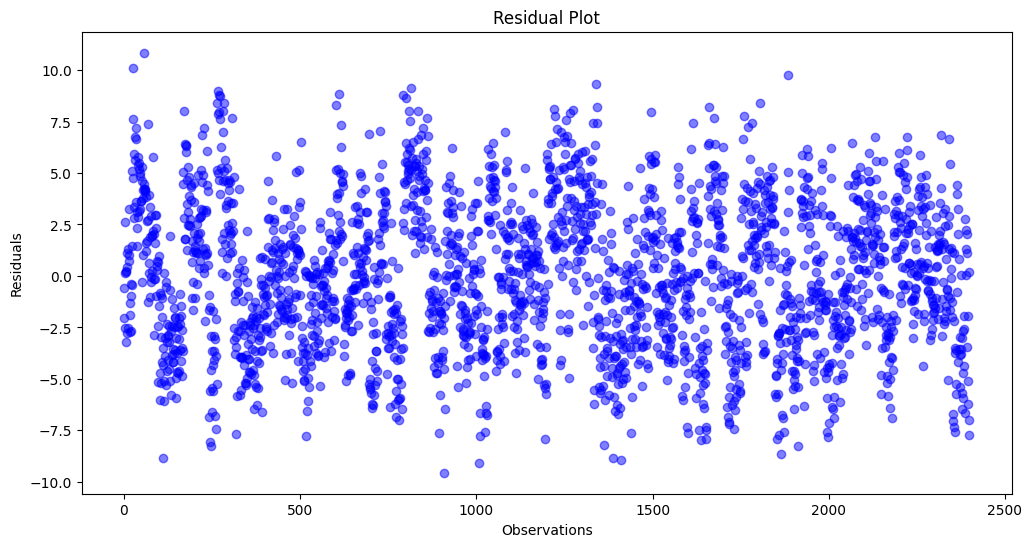


R-squared: 0.7018340643866059


In [16]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
from scipy.stats import norm  # Import norm from scipy.stats

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_households = 100
n_hours = 24
treatment_households = 50

# Create base DataFrame with correct household IDs
households = np.repeat(np.arange(n_households), n_hours)
df = pd.DataFrame({
    'household_id': households,
    'hour': np.tile(np.arange(n_hours), n_households),
    'treatment': np.repeat(np.concatenate([np.ones(treatment_households), np.zeros(n_households - treatment_households)]), n_hours)
})

# Function to generate energy usage
def generate_energy_usage(hour, is_treatment, base_load, peak_load, peak_hours, pre_cooling_hours):
    if is_treatment:
        if hour in peak_hours:
            return base_load * 0.8  # Reduced load during peak hours for treatment group
        elif hour in pre_cooling_hours:
            return base_load * 1.2  # Increased load during pre-cooling for treatment group
        else:
            return base_load
    else:
        if hour in peak_hours:
            return peak_load  # Higher load during peak hours for control group
        else:
            return base_load

# Generate energy usage
base_loads = np.random.uniform(25, 35, n_households)  # Random base load kW per household
peak_loads = np.random.uniform(40, 50, n_households)  # Random peak load kW per household
peak_hours = range(11, 16)  # 11 AM to 3 PM
pre_cooling_hours = range(7, 11)  # 7 AM to 10 AM

# Vectorized operation to generate energy usage for each household
df['energy_usage'] = [
    generate_energy_usage(hour, treatment, base_loads[household], peak_loads[household], peak_hours, pre_cooling_hours)
    for hour, treatment, household in zip(df['hour'], df['treatment'], df['household_id'])
]

# Add some random noise
df['energy_usage'] += np.random.normal(0, 2, len(df))

# Ensure non-negative energy usage
df['energy_usage'] = df['energy_usage'].clip(lower=0)

# Add temperature data (assuming it's the same for all households)
temp_base = 70  # Base temperature
temp_peak = 95  # Peak temperature
temp_curve = norm.pdf(np.arange(n_hours), loc=12, scale=4)  # Normal distribution centered at noon
temp_curve = (temp_curve - temp_curve.min()) / (temp_curve.max() - temp_curve.min())
temperatures = temp_base + temp_curve * (temp_peak - temp_base)
df['temperature'] = df['hour'].map(dict(enumerate(temperatures)))

# Convert hour to categorical
df['hour2'] = pd.Categorical(df['hour'])

# Assuming x1 is a variable of interest (randomly generated for demonstration)
df['x1'] = np.random.normal(0, 1, size=len(df))

# Create a panel DataFrame
df_s = df.set_index(['household_id', 'hour'])

# Specify the regression model
mod = PanelOLS.from_formula('energy_usage ~ 1 + hour2*treatment', drop_absorbed=True, check_rank=False, data=df_s)

# Fit the model
res = mod.fit()

# Print regression results
print(res)

# Additional diagnostics
print(res.summary)

# Plot residuals
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(res.resids.values, marker='o', linestyle='None', color='b', alpha=0.5)
ax.set_xlabel('Observations')
ax.set_ylabel('Residuals')
ax.set_title('Residual Plot')
plt.show()

# Access specific statistics from the results
print("\nR-squared:", res.rsquared)

**Model Summary**

Dependent Variable: energy_usage  
Estimator: PanelOLS (Panel Ordinary Least Squares)

**R-squared:**  
-  Overall: 0.7018  
-  Between: 0.3381  
-  Within: 0.8332  


  
**Key Points of Interest**

Significance of Interaction Terms: The interaction terms between hour2 (which represents different hours of the day) and treatment (a binary treatment indicator) are included in the model. For instance, hour2[T.7]:treatment has a coefficient estimate of 6.5031 with a very low p-value, indicating statistical significance. This suggests that the effect of the treatment varies significantly depending on the hour of the day.  

-  Hourly Effects: The coefficients for hour2[T.11], hour2[T.12], hour2[T.13], hour2[T.14], and hour2[T.15] are notably large and statistically significant. This indicates that energy usage during these hours (typically daytime) is significantly different compared to the reference category (presumably hour 1).

-  Treatment Effect: The main effect of treatment itself (-0.7115) is not statistically significant (p-value = 0.3190). However, its interaction with certain hours (hour2) shows significant variation, indicating that the treatment effect is conditional on the hour of the day.

-  Support for Model Validity
R-squared Values: The overall R-squared of 0.7018 suggests that the model explains approximately 70.18% of the variance in energy usage, which is reasonably high for this type of panel data.

-  PanelOLS Estimation: PanelOLS is appropriate for panel data analysis where both cross-sectional and time-series dimensions are present. It corrects for potential biases that can arise from individual-specific or time-specific effects.

-  Statistical Significance: Many of the coefficients, particularly those for the interaction terms (hour2[T.i]:treatment), are statistically significant at conventional levels (p < 0.05), indicating robust relationships.

-  Reasoning for Interaction Terms
The interaction terms (hour2[T.i]:treatment) are crucial because they allow us to assess whether the treatment effect varies across different hours of the day. For example: hour2[T.7]:treatment = 6.5031 means that the treatment effect at hour 7 is estimated to increase energy usage by 6.5031 units compared to its baseline effect.  


These terms help capture any differential impact of the treatment during specific times of the day, providing more nuanced insights into temporal effects.


**Conclusion**
The model appears valid due to its high R-squared, appropriate use of PanelOLS for panel data, and statistically significant coefficients for key interaction terms. The inclusion of interaction terms allows for a more precise understanding of how the treatment affects energy usage across different hours of the day, providing actionable insights for further analysis or policy implications.

# Calculating Treatment Effect

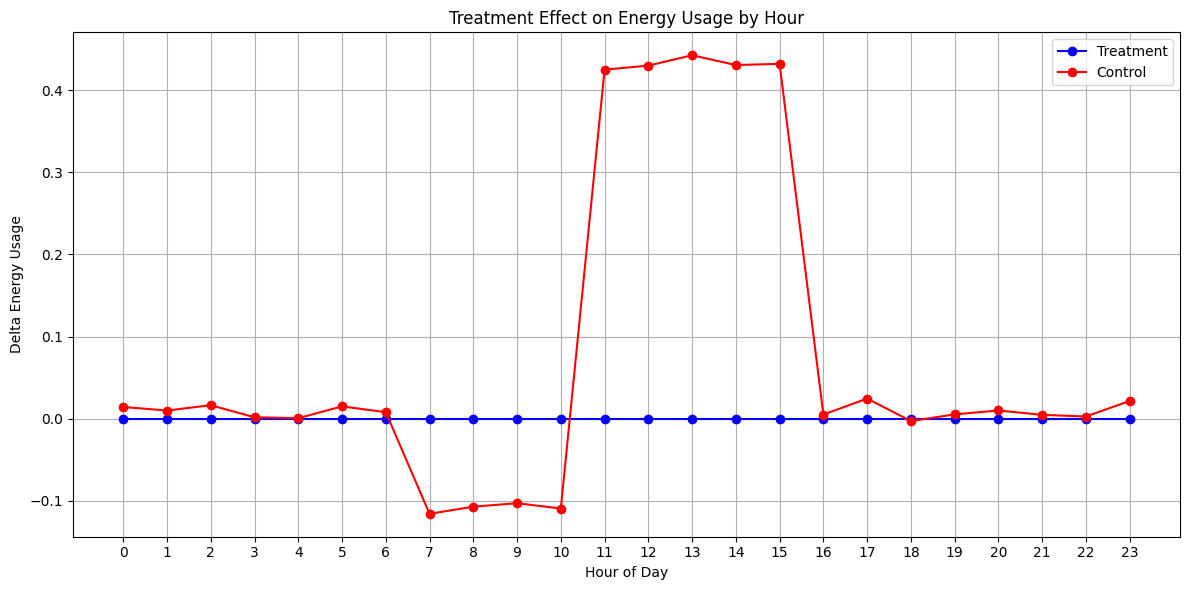

In [23]:
import matplotlib.pyplot as plt

# Aggregate by hour and calculate mean delta energy
df_hourly = df.groupby(['hour', 'treatment'])['delta_energy'].mean().reset_index()

# Separate treatment and control data
df_treatment = df_hourly[df_hourly['treatment'] == 1]
df_control = df_hourly[df_hourly['treatment'] == 0]

# Sort data by hour for better visualization
df_treatment_sorted = df_treatment.sort_values(by='hour')
df_control_sorted = df_control.sort_values(by='hour')

# Plotting treatment effect over hours
fig, ax = plt.subplots(figsize=(12, 6))

# Line plot for treatment group
ax.plot(df_treatment_sorted['hour'], df_treatment_sorted['delta_energy'], marker='o', linestyle='-', color='b', label='Treatment')

# Line plot for control group
ax.plot(df_control_sorted['hour'], df_control_sorted['delta_energy'], marker='o', linestyle='-', color='r', label='Control')

ax.set_xlabel('Hour of Day')
ax.set_ylabel('Delta Energy Usage')
ax.set_title('Treatment Effect on Energy Usage by Hour')
ax.legend()
plt.xticks(np.arange(0, 24, 1))
plt.grid(True)
plt.tight_layout()

plt.show();